In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd

from shapely.wkt import loads
from shapely.geometry import Polygon

import os

In [2]:
files = {'marine_protected_areas': ('../data/PR100/Habitat/marine_protected_areas.parquet',
  'EPSG:32161',
  'centroid'),
 'land_nationwide_hapc': ('../data/PR100/Habitat/land_nationwide_hapc.parquet',
  'EPSG:32161',
  'centroid'),
 'artificial_reefs': ('../data/PR100/Habitat/artificial_reefs.parquet',
  'EPSG:32161',
  'irrelevant'),
 'nationwide_hapc': ('../data/PR100/Habitat/nationwide_hapc.parquet',
  'EPSG:32161',
  'irrelevant'),
 'areas_protegidas_agencia': ('../data/PR100/Habitat/areas_protegidas_agencia.parquet',
  'EPSG:32161',
  'centroid'),
 'noaa_charted_submarine_cables_30m_buffer': ('../data/PR100/Infrastructure/noaa_charted_submarine_cables_30m_buffer.parquet',
  'EPSG:32161',
  'irrelevant'),
 'setbacks_xmission': ('../data/PR100/Infrastructure/setbacks_xmission.parquet',
  'EPSG:32161',
  'lines'),
 'submarine_cable_30m_buffer': ('../data/PR100/Infrastructure/submarine_cable_30m_buffer.parquet',
  'EPSG:32161',
  'irrelevant'),
 'pipeline_areas': ('../data/PR100/Infrastructure/pipeline_areas.parquet',
  'EPSG:32161',
  'irrelevant'),
 'setbacks_roads': ('../data/PR100/Infrastructure/setbacks_roads.parquet',
  'EPSG:4326',
  'density'),
 'setbacks_runway': ('../data/PR100/Infrastructure/setbacks_runway.parquet',
  'EPSG:4326',
  'centroid'),
 'setbacks_airport': ('../data/PR100/Infrastructure/setbacks_airport.parquet',
  'EPSG:4326',
  'points'),
 'setbacks_buildings': ('../data/PR100/Infrastructure/setbacks_buildings.parquet',
  'EPSG:4326',
  'density'),
 'federal_and_state_waters': ('../data/PR100/Boundaries/federal_and_state_waters.parquet',
  'EPSG:32161',
  'centroid'),
 'coastal_zone_mgmt_act_boundary': ('../data/PR100/Boundaries/coastal_zone_mgmt_act_boundary.parquet',
  'EPSG:32161',
  'centroid'),
 'land_protected_areas': ('../data/PR100/Boundaries/land_protected_areas.parquet',
  'EPSG:32161',
  'centroid'),
 'water_bodies': ('../data/PR100/Topography/water_bodies.parquet',
  'EPSG:4326',
  'centroid'),
 'wrecks_and_obstructions': ('../data/PR100/Hazards/wrecks_and_obstructions.parquet',
  'EPSG:4326',
  'points'),
 'ocean_disposal_sites': ('../data/PR100/Hazards/ocean_disposal_sites.parquet',
  'EPSG:32161',
  'centroid'),
 'tropical_cyclone_storm_segments': ('../data/PR100/Hazards/tropical_cyclone_storm_segments.parquet',
  'EPSG:32161',
  'lines'),
 'tropical_cyclone_wind_exposure': ('../data/PR100/Hazards/tropical_cyclone_wind_exposure.parquet',
  'EPSG:32161',
  'wind_exposure'),
 'unexploded_ordinance_areas_fuds': ('../data/PR100/Hazards/unexploded_ordinance_areas_fuds.parquet',
  'EPSG:32161',
  'irrelevant'),
 'danger_zones_and_restricted_areas': ('../data/PR100/Hazards/danger_zones_and_restricted_areas.parquet',
  'EPSG:32161',
  'centroid'),
 'unexploded_ordinance_areas': ('../data/PR100/Hazards/unexploded_ordinance_areas.parquet',
  'EPSG:4326',
  'centroid')}

In [3]:
binary_mask_columns = ['marine_protected_areas', 'land_nationwide_hapc',
       'areas_protegidas_agencia', 'setbacks_xmission',
       'setbacks_runway', 'setbacks_airport',
       'federal_and_state_waters', 'coastal_zone_mgmt_act_boundary',
       'land_protected_areas', 'water_bodies', 'wrecks_and_obstructions',
       'ocean_disposal_sites', 'danger_zones_and_restricted_areas',
       'unexploded_ordinance_areas']

In [4]:
def find_parquet_files(directory):
    """
    Find all Parquet files within a directory and its subdirectories.

    :param directory: The base directory to search.
    :return: A list of paths to Parquet files.

    Note: This function isn't used in this notebook, because the file list
    has already been generated and enriched (see 'files' dict above)
    """
    parquet_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.parquet'):
                parquet_files.append(os.path.join(root, file))
    return parquet_files

In [5]:
def get_gdf(parquet_file, crs, grid):
    df = pd.read_parquet(parquet_file)
    df['geometry'] = df['geometry'].apply(loads)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.set_crs(crs, inplace=True)
    gdf.to_crs(grid.crs, inplace=True)
    return gdf

In [6]:
def create_grid(x_start, x_end, y_start, y_end, square_size):
    grid = []
    for x in np.arange(x_start, x_end, square_size):
        for y in np.arange(y_start, y_end, square_size):
            # Define the square's coordinates
            square = Polygon([(x, y), (x + square_size, y), (x + square_size, y + square_size), (x, y + square_size)])
            grid.append(square)
    return gpd.GeoDataFrame({'geometry': grid}, crs="EPSG:32161")

In [7]:
def calculate_cyclone_risk_score(df):
    # Normalize the wind speed occurrences
    max_occurrence = df[['occurrence34kt', 'occurrence50kt', 'occurrence64kt']].max().max()
    df['norm_occurrence34kt'] = df['occurrence34kt'] / max_occurrence
    df['norm_occurrence50kt'] = df['occurrence50kt'] / max_occurrence
    df['norm_occurrence64kt'] = df['occurrence64kt'] / max_occurrence

    # Normalize major hurricanes occurrences
    max_major_hurricanes = df['occurrence64ktMajorHurricanes'].max()
    df['norm_major_hurricanes'] = df['occurrence64ktMajorHurricanes'] / max_major_hurricanes

    # Normalize intersecting storm tracks
    max_intersecting = df['intersectingStormTracks'].max()
    df['norm_intersectingTracks'] = df['intersectingStormTracks'] / max_intersecting

    # Assign weights and calculate risk score
    weights = {
        'norm_occurrence34kt': 0.1,
        'norm_occurrence50kt': 0.2,
        'norm_occurrence64kt': 0.3,
        'norm_major_hurricanes': 0.3,
        'norm_intersectingTracks': 0.1
    }

    df['cyclone_risk_score'] = sum(df[col] * weight for col, weight in weights.items())

    return df

In [8]:
def rasterize_cyclone_risk(grid_gdf, cyclone_data_gdf):
    # Ensure both dataframes are in the same CRS
    cyclone_data_gdf = cyclone_data_gdf.to_crs(grid_gdf.crs)

    # Spatial join - to associate cyclone data with each grid cell
    joined_gdf = gpd.sjoin(grid_gdf, cyclone_data_gdf, how='left', predicate='intersects')

    # Apply the risk score calculation to each row
    joined_gdf = calculate_cyclone_risk_score(joined_gdf)

    # Group by grid cell index and average the scores within each cell
    aggregated_scores = joined_gdf.groupby(joined_gdf.index)['cyclone_risk_score'].mean()

    return aggregated_scores.reindex(grid_gdf.index, fill_value=0)

In [9]:
def rasterize(grid, data, type):
    joined_gdf = gpd.sjoin(grid, data[['geometry']], how='right', predicate='intersects')
    count = joined_gdf.groupby('index_left').size().reindex(grid.index, fill_value=0)
    if type == 'density':
        return count
    else:
        return count > 0

In [10]:
def process_file(file_path, crs, type, handle, grid):
    gdf = get_gdf(file_path, crs, grid)
    if type == 'irrelevant':
        pass
    elif type == 'wind_exposure':
        grid[handle] = rasterize_cyclone_risk(grid, gdf)
    else:
        grid[handle] = rasterize(grid, gdf, type)

In [11]:
def process_all_files(files, grid):
    for handle, file_data in files.items():
        file_path = file_data[0]
        crs = file_data[1]
        type = file_data[2]
        print(f'Processing file: {file_path}')
        process_file(file_path, crs, type, handle, grid)

In [12]:
def create_final_binary_mask(grid, binary_mask_columns):
    """
    Create a final binary mask column in the grid dataframe, which is True if any of 
    the specified binary mask columns are True.

    :param grid: DataFrame containing the grid information.
    :param binary_mask_columns: List of columns to be considered for the binary mask.
    :return: Updated DataFrame with an additional 'final_binary_mask' column.
    """

    # Check if any of the specified columns are True for each row
    grid['final_binary_mask'] = grid[binary_mask_columns].any(axis=1)

    return grid

In [13]:
environment_gdf = create_grid(100000, 300000, 200000, 300000, 500)

In [14]:
process_all_files(files, environment_gdf)

Processing file: ../data/PR100/Habitat/marine_protected_areas.parquet
Processing file: ../data/PR100/Habitat/land_nationwide_hapc.parquet
Processing file: ../data/PR100/Habitat/artificial_reefs.parquet
Processing file: ../data/PR100/Habitat/nationwide_hapc.parquet
Processing file: ../data/PR100/Habitat/areas_protegidas_agencia.parquet
Processing file: ../data/PR100/Infrastructure/noaa_charted_submarine_cables_30m_buffer.parquet
Processing file: ../data/PR100/Infrastructure/setbacks_xmission.parquet
Processing file: ../data/PR100/Infrastructure/submarine_cable_30m_buffer.parquet
Processing file: ../data/PR100/Infrastructure/pipeline_areas.parquet
Processing file: ../data/PR100/Infrastructure/setbacks_roads.parquet
Processing file: ../data/PR100/Infrastructure/setbacks_runway.parquet
Processing file: ../data/PR100/Infrastructure/setbacks_airport.parquet
Processing file: ../data/PR100/Infrastructure/setbacks_buildings.parquet
Processing file: ../data/PR100/Boundaries/federal_and_state_wat

In [15]:
environment_gdf = create_final_binary_mask(environment_gdf, binary_mask_columns)

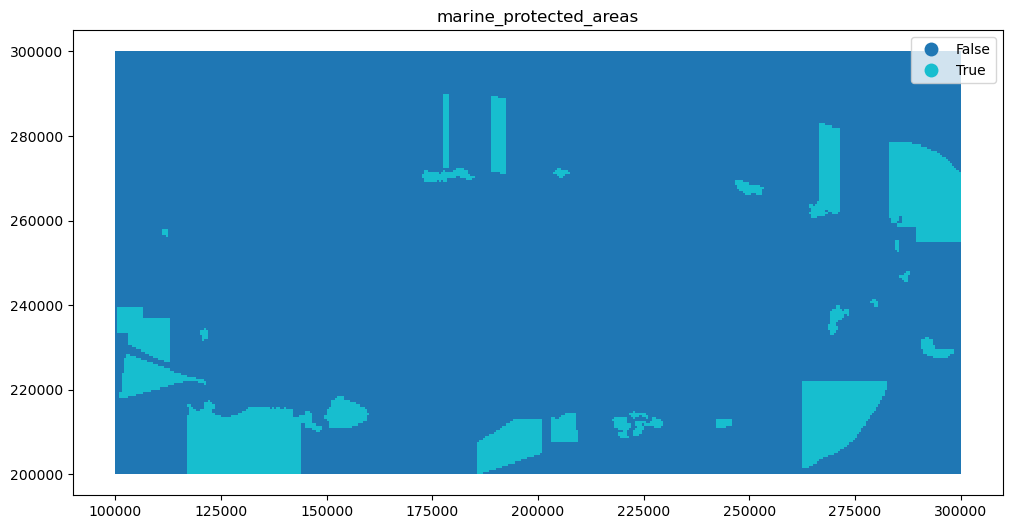

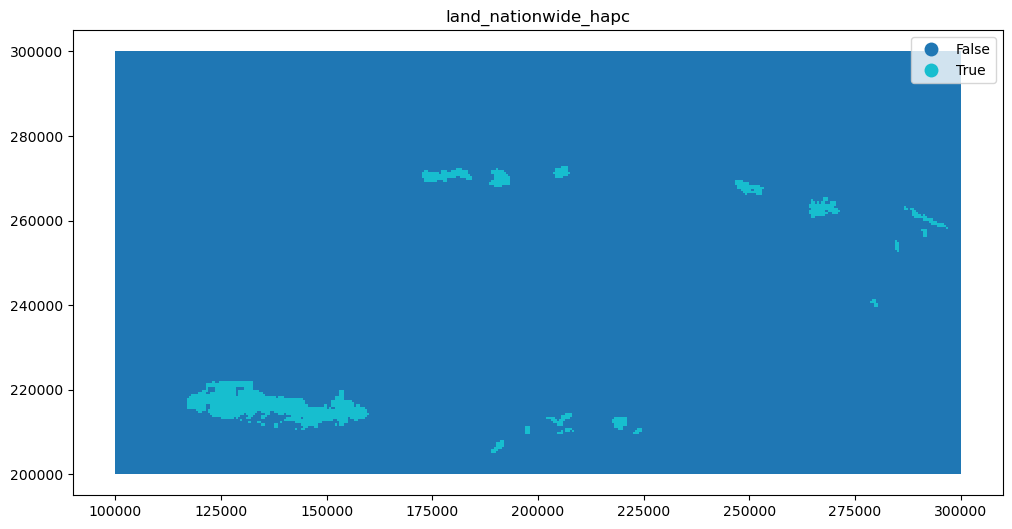

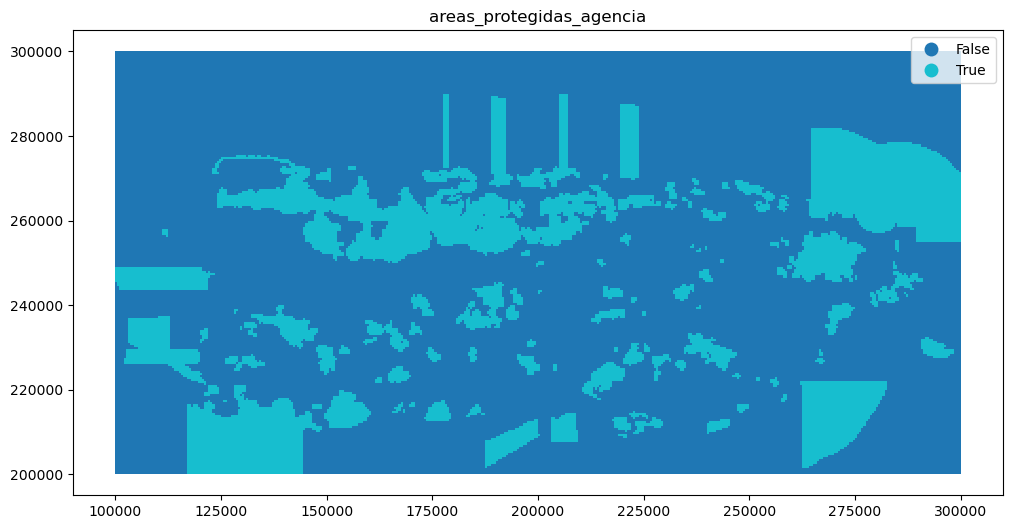

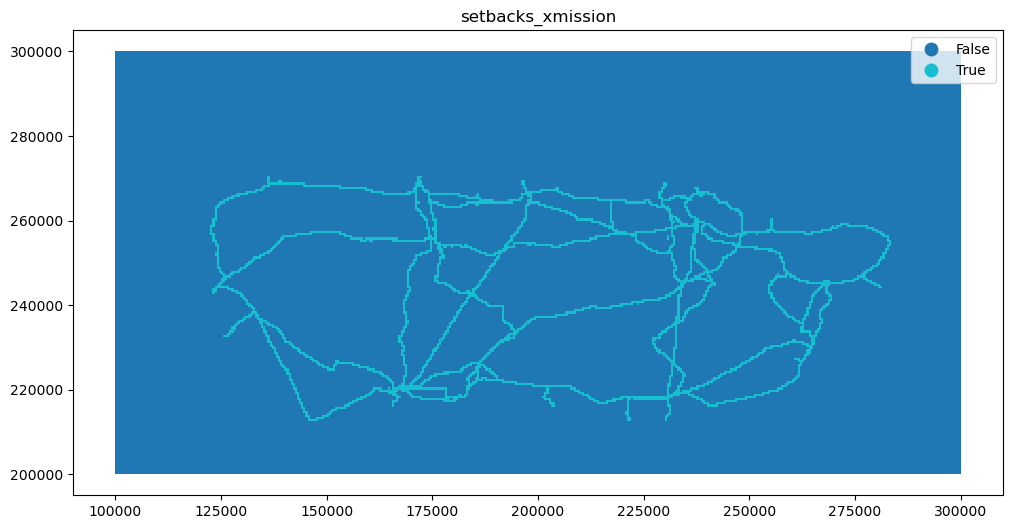

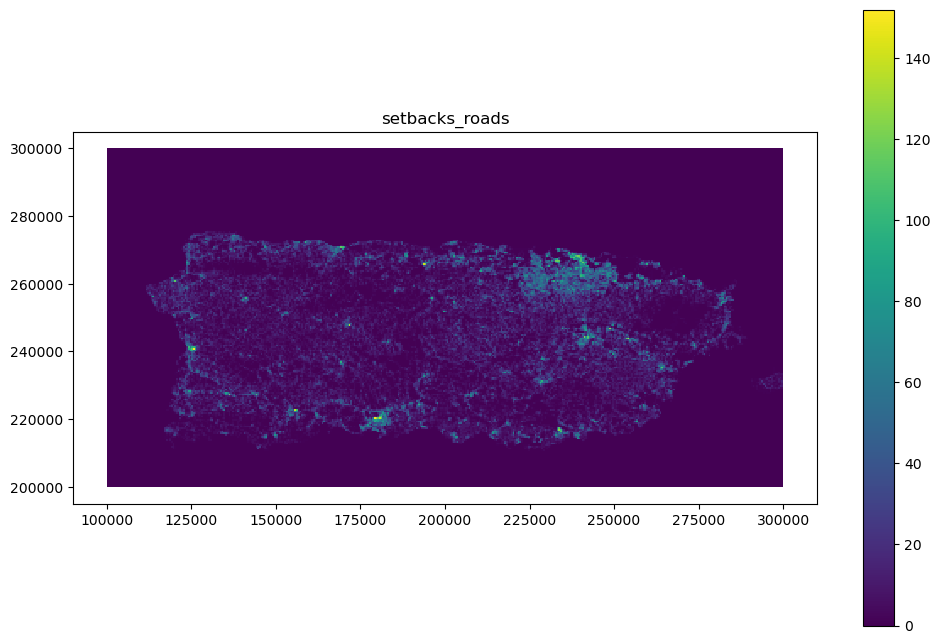

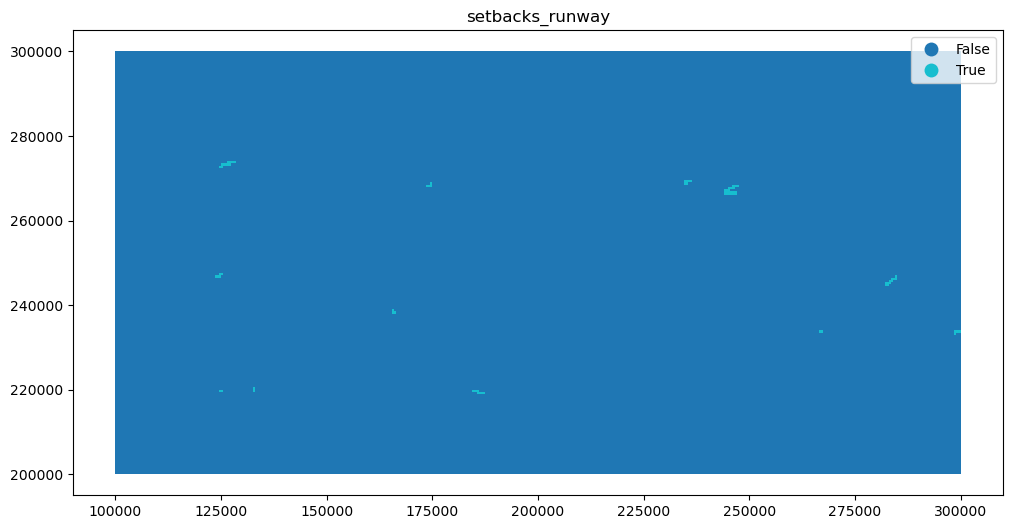

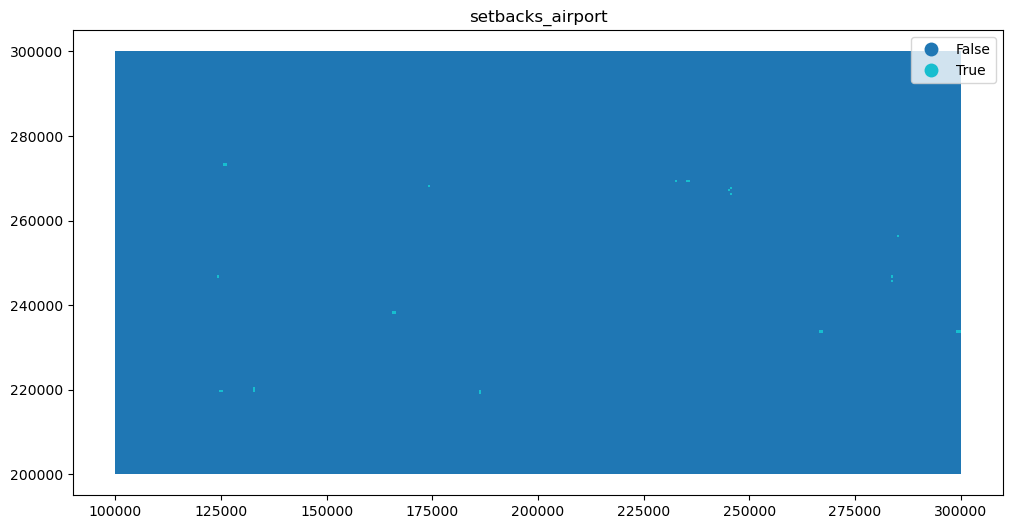

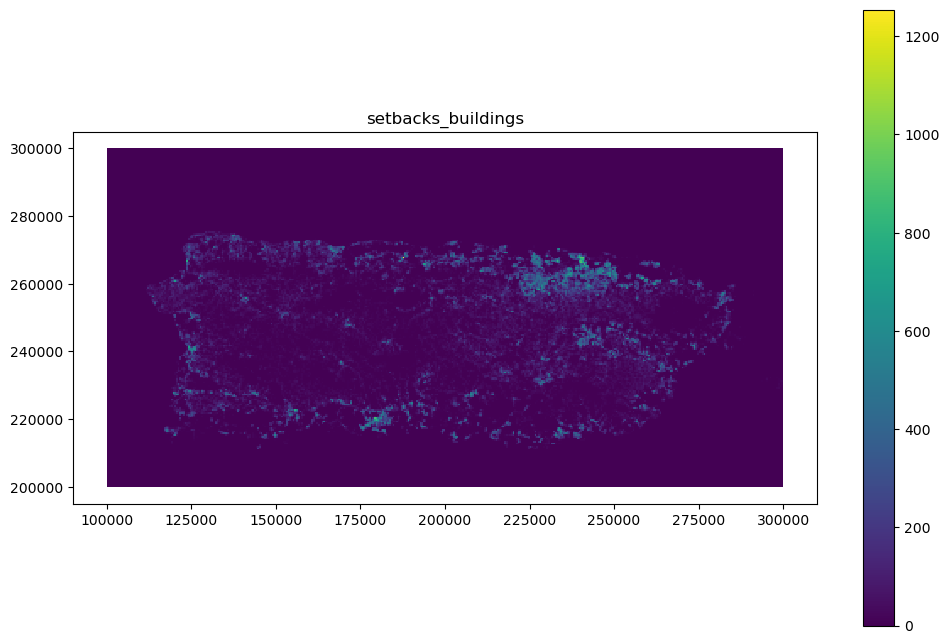

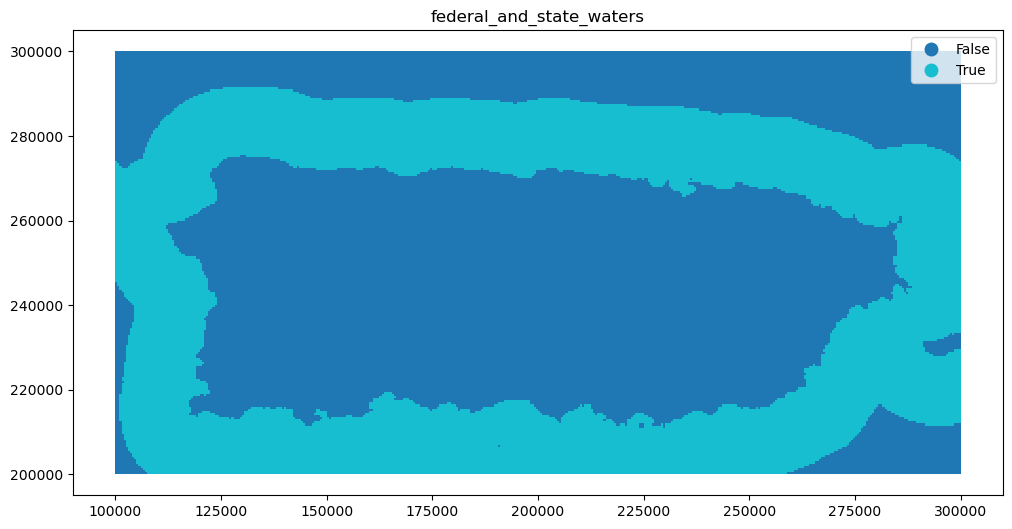

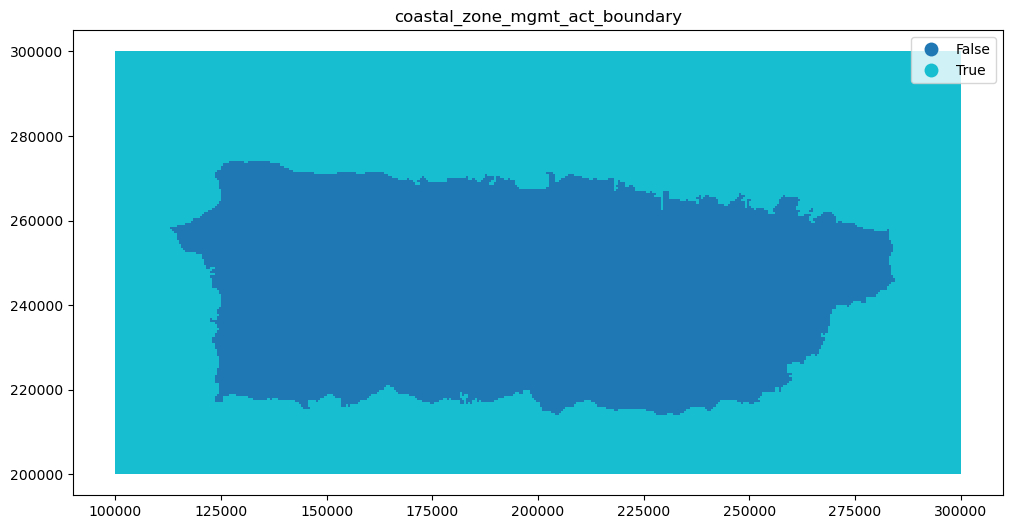

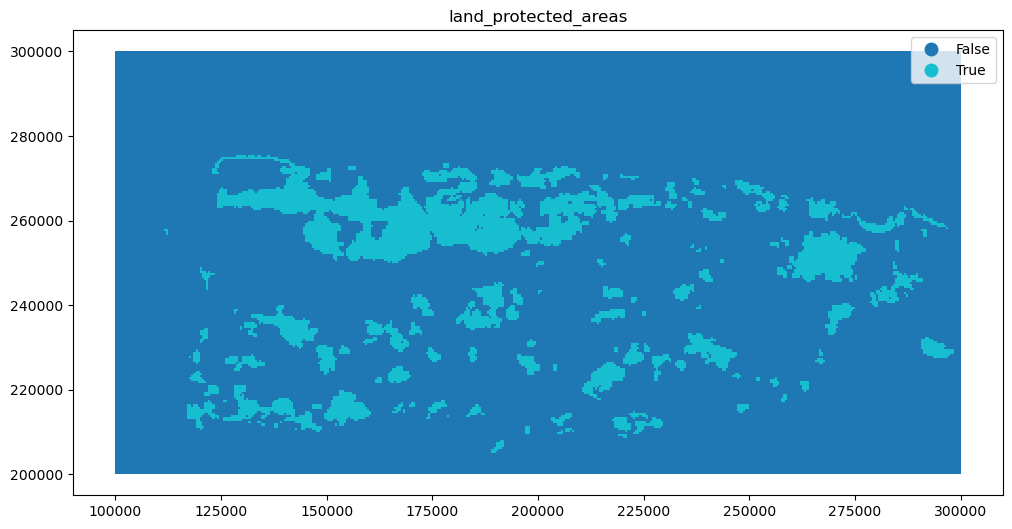

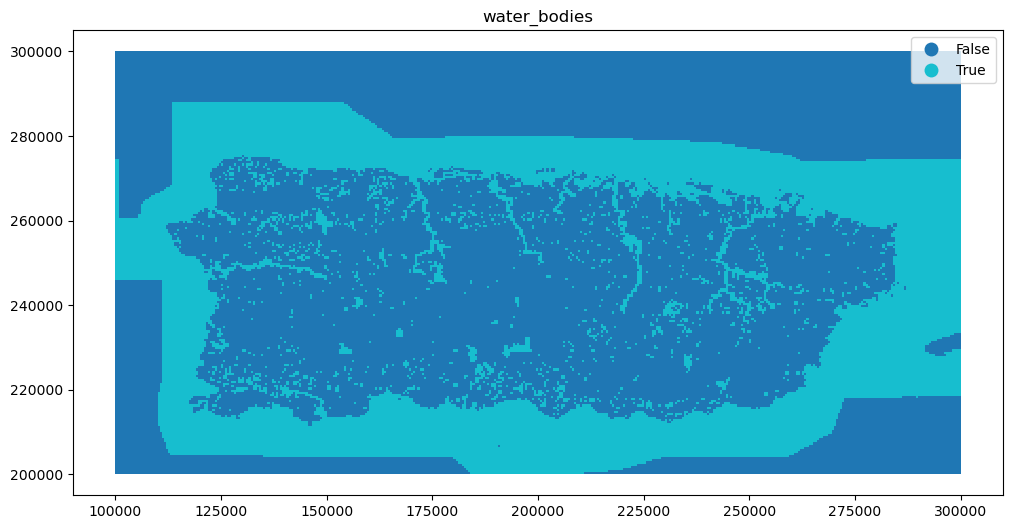

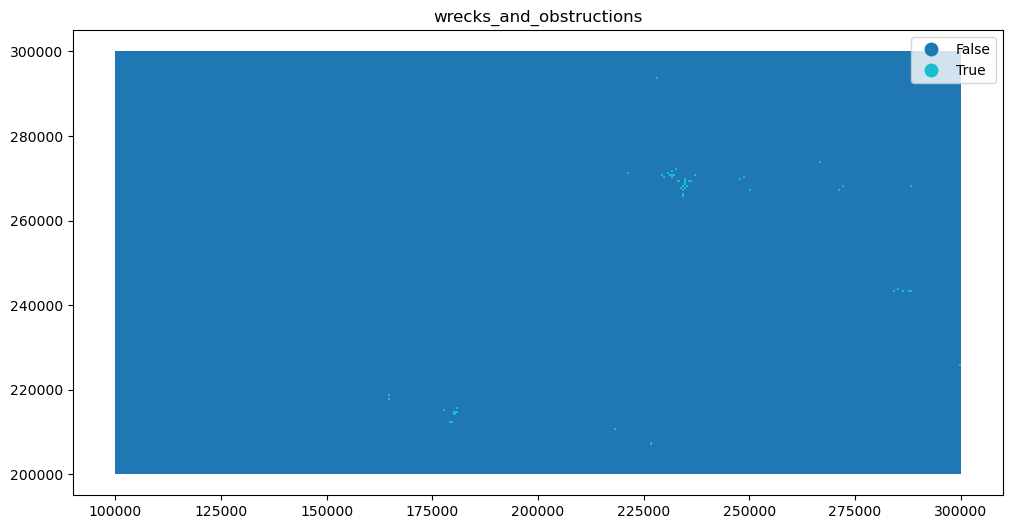

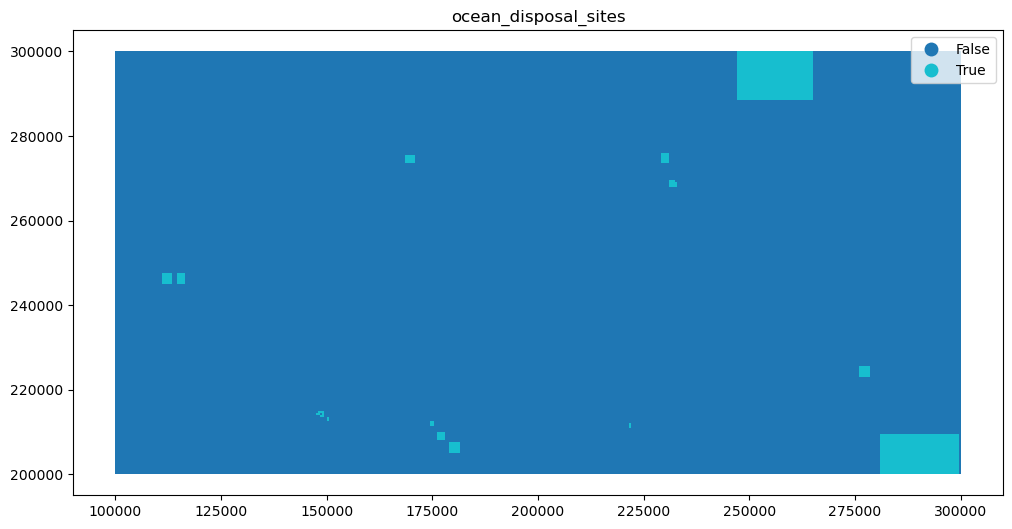

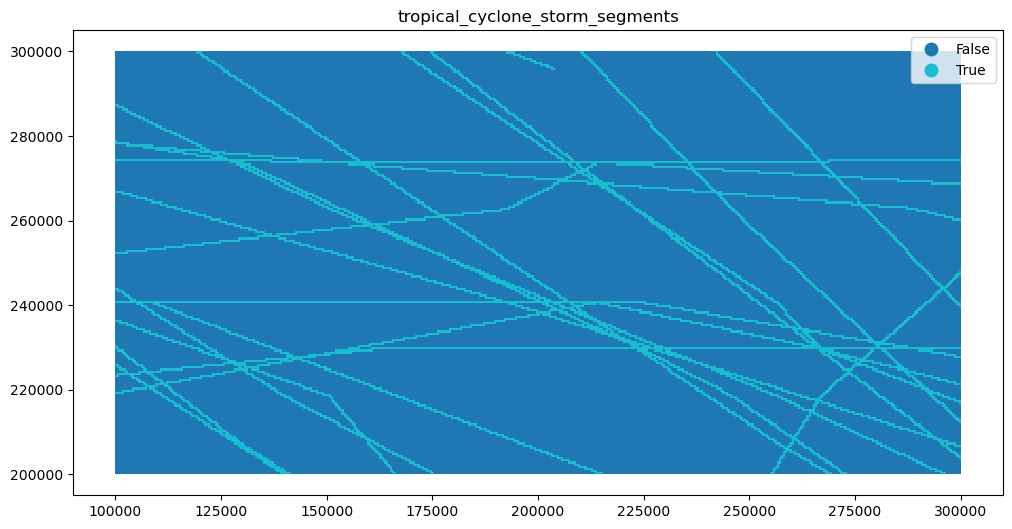

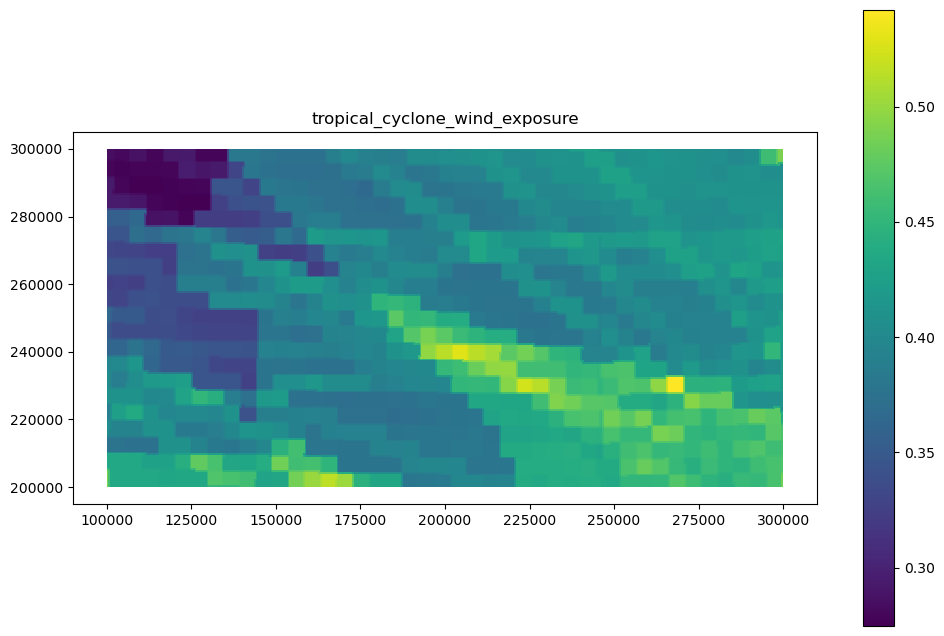

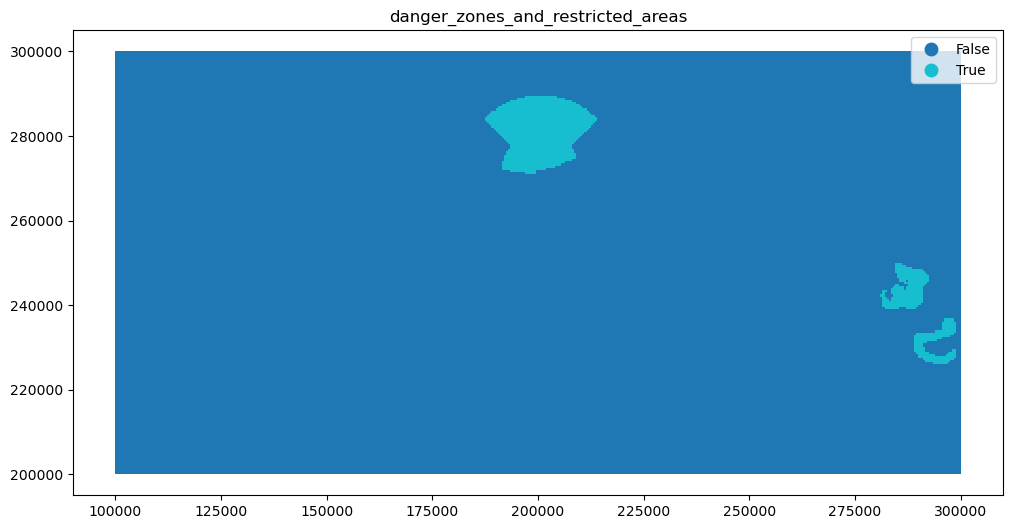

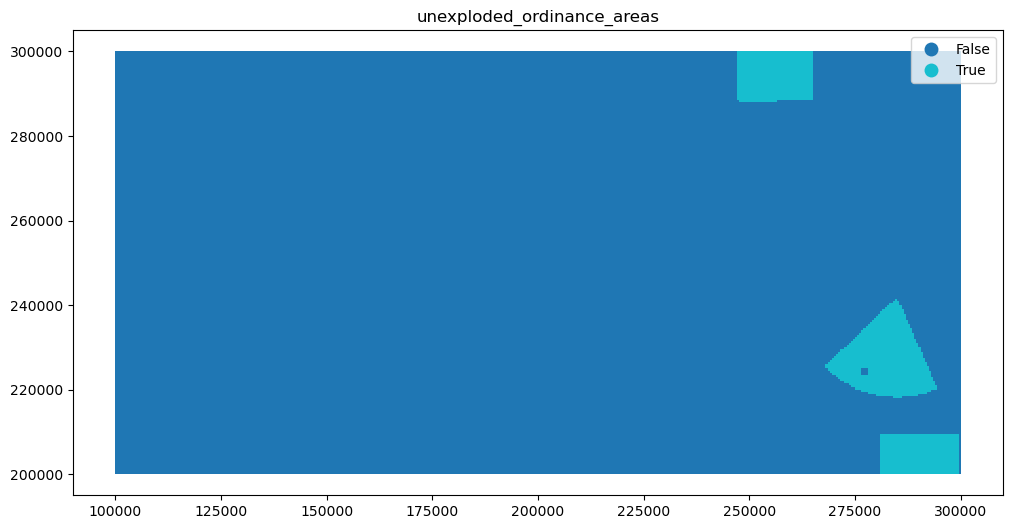

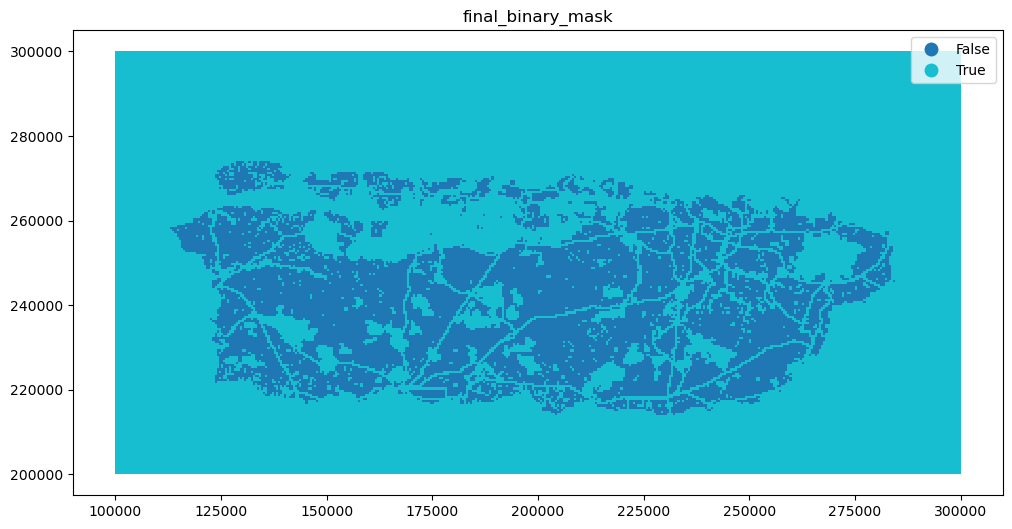

In [16]:
for column in environment_gdf.columns:
    if column == 'geometry':
        continue
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    environment_gdf.plot(column=column, ax=ax, legend=True)
    plt.title(column)
    plt.show()